# <font color='#31394d'> Practical Exercise: Logistic Regression </font>

In this module, we'll be exploring how to build a logistic regression model using scikit-learn. Remember, logistic regression is a binary classification algorithm, so instead of predicting a number (regression) or a group of labels (i.e. multi-class classification) we'll be predicting either true (1) or false (0). Let's start by importing our usual toolkit.

In [1]:
import pandas as pd
import numpy as np

## <font color='#31394d'> Breast Cancer Data </font>

We are going to use the [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). It is a dataset that contains measurements taken on breast cancer cell images. The goal of the dataset is to predict whether a cancer tumor is benign or malignant.


![title](media/breast_cancer.png)

In [2]:
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()
cancer_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [3]:
print(cancer_data["DESCR"])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

This dataset is a binary classification problem, where the target variable indicates whether a tumor is malignant or benign, encoded as 0 and 1, respectively. The features are measurements taken from the cell images, mostly measures of the cell nucleii.

In [4]:
cancer_data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [5]:
pd.Series(cancer_data["target"]).value_counts(normalize=True).sort_index()

0    0.372583
1    0.627417
dtype: float64

In this dataset, 62.7% of tumors are benign and 37.3% are malignant.

There are lots of features in this dataset. Let's limit ourselves to just the "mean" features:

In [6]:
cancer_data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [7]:
df = pd.DataFrame(cancer_data["data"], columns=cancer_data.feature_names)

df = df[df.columns[df.columns.str.startswith('mean')]]

df['target'] = cancer_data.target
print('The dataset has', df.shape[0], 'rows and', df.shape[1], 'features')
df.head()

The dataset has 569 rows and 11 features


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0


Its always a good idea to check that our variables are of the expected data types. Any non-numerical variables would need to be converted to numeric variables (e.g. via one-hot encoding) before we can fit a model.

In [8]:
df.dtypes

mean radius               float64
mean texture              float64
mean perimeter            float64
mean area                 float64
mean smoothness           float64
mean compactness          float64
mean concavity            float64
mean concave points       float64
mean symmetry             float64
mean fractal dimension    float64
target                      int32
dtype: object

Let's split our dataset into training and test sets:

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.target, test_size=0.2, random_state=12345)


print('The training set has', X_train.shape[0], 'rows')
print('The test set has', X_test.shape[0], 'rows')

The training set has 455 rows
The test set has 114 rows


Shortly, we will be fitting our first logistic regression model. From an optimisation point of view, this involves finding the coefficients that minimise the cross-entropy loss function. The internal procedures that perform this operation work best if the features are *standardized*; that is, for each feature, we subtract its mean and divide by its standard deviation. This ensures that all features have the same scale, but doesn't change the nature of the relationship between the features and the target variable.

We can do this in `sklearn` by instantiating a `StandardScaler` object from the `preprocessing` submodule. We use the `fit_transform` method to compute the means and standard deviations for the training data and then apply the transformation to the training data. We then use the `transform` method to standardize the test data using the means and standard deviations estimated from the training set. 

🙋‍♀️ <font color='#d9c4b1'> Question: </font> Why do we not apply the `fit_transform` method on the test set?

    Because the test set is not used to fit the model, so we don't want to use it to estimate the means and standard deviations. We want to use the means and standard deviations estimated from the training set to standardize the test set.

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [11]:
pd.DataFrame(X_train, columns=df.columns[:-1]) # just so you can see what the transformed data looks like

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
0,3.707522,0.636479,3.689347,4.490213,0.916322,1.606814,2.440709,3.519566,-0.046691,-0.745130
1,-0.846158,0.527808,-0.869192,-0.778375,0.378619,-0.850715,-1.001404,-0.982007,-0.703805,-0.206592
2,-0.786614,-0.067518,-0.819157,-0.734134,-0.659290,-1.031827,-0.815342,-0.703074,0.709879,-0.478741
3,-0.403833,-0.355732,-0.457836,-0.437412,-1.237321,-1.122570,-0.938723,-0.789017,-1.257912,-1.070557
4,-0.157151,-0.315571,-0.242111,-0.237342,-1.200530,-1.210326,-0.865090,-0.940815,-0.852988,-1.105115
...,...,...,...,...,...,...,...,...,...,...
450,-0.729906,-0.032082,-0.735901,-0.695529,-0.777443,-0.525086,-0.433442,-0.892504,0.773814,-0.029479
451,1.600807,1.404261,1.569001,1.508897,0.357394,0.999994,2.037276,1.665947,1.381201,-0.251230
452,-0.443528,-0.183276,-0.505001,-0.472071,-0.885691,-1.179705,-1.089206,-1.181252,-0.412544,-0.622735
453,-0.480389,-0.653395,-0.381143,-0.506731,-0.092579,0.854357,0.798514,-0.023414,0.954965,1.493979


## <font color='#31394d'> Logistic Regression in Scikit-Learn </font>

In this section, we will fit a logistic regression model and use it to make predictions. Take note of how similar the process is to linear regression. This is the case for all estimators in `sklearn` and is the primary reason for the module's popularity. Even though the models are very different, the training and prediction steps look almost identical in `sklearn`!



In [12]:
from sklearn.linear_model import LogisticRegression
?LogisticRegression

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

<font color='#d9c4b1'> A side note... </font>

Note (from the help file) that `LogisticRegression` has a `penalty` argument that is set to `l2` by default. This is an example of *regularization* - a technique that introduces some bias (a simpler model) in an attempt to reduce sampling variability (the bias-variance trade-off!). In linear regression, an `l2` penalty leads to ridge regression, while the `l1` penalty corresponds to the lasso. Importantly, if you are going to use a regularized model, then you **MUST** always standardize your features.

We are going to ignore the penalty for the rest of this notebook and fit a standard logistic regression model...

In [13]:
clf = LogisticRegression(penalty='none') # instantiate the model

In [14]:
clf.fit(X=X_train, y=y_train) 

LogisticRegression(penalty='none')

## <font color='#31394d'> Interpretation </font>

We can examine the estimated coefficients in the usual way. Note that because we standardized our features, the absolute values of the coefficients give us a measure of feature importance:

In [15]:
clf.coef_

array([[  7.19487054,  -1.60430416,   3.01201434, -14.91546234,
         -1.01345318,   0.21490822,  -0.26285507,  -3.9696922 ,
         -0.47854287,   0.52456356]])

In [16]:
df.columns[:-1]

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension'],
      dtype='object')

In [17]:
pd.Series(clf.coef_[0], index=df.columns[:-1]).sort_values()

mean area                -14.915462
mean concave points       -3.969692
mean texture              -1.604304
mean smoothness           -1.013453
mean symmetry             -0.478543
mean concavity            -0.262855
mean compactness           0.214908
mean fractal dimension     0.524564
mean perimeter             3.012014
mean radius                7.194871
dtype: float64

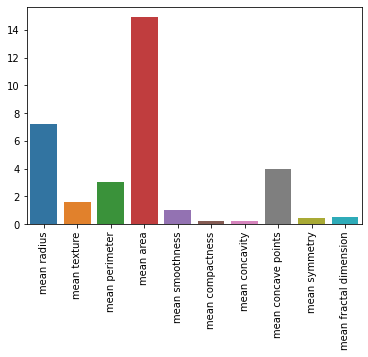

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=df.columns[:-1], y=np.abs(clf.coef_[0]))
plt.xticks(rotation=90);


Area and radius look like the most important features for classifying cancer tumors.

## <font color='#31394d'> Predictions </font>

Let's now make some predictions on the test data:

In [29]:
y_hat = clf.predict(X_test)
y_hat[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0])

We see that the `predict` method directly outputs the predicted class (0 or 1), assuming a classification threshold of 0.5. If we want to see the underlying probabilities, we can use the `predict_proba` method:

In [20]:
y_prob = clf.predict_proba(X_test)
np.around(y_prob[:20,:], 2) # rounding to 2 decimal places

array([[0.01, 0.99],
       [0.  , 1.  ],
       [0.03, 0.97],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.03, 0.97],
       [0.  , 1.  ],
       [0.32, 0.68],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.02, 0.98],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.12, 0.88],
       [0.99, 0.01]])

🙋‍♀️ <font color='#d9c4b1'> Question: </font> Why are there two columns of results here?

The two columns represent the probabilities of the two classes. The first column is the probability of class 0 (benign) and the second column is the probability of class 1 (malignant). The `predict` method uses a threshold of 0.5 to determine the predicted class. If the probability of class 1 is greater than 0.5, then the predicted class is 1, otherwise it is 0.

🚀 <font color='#d9c4b1'> Exercise: </font> Using the estimated probabilities, confirm that the `predict` method does indeed use a 0.5 classification threshold.

In [21]:
# confirm that the predict method use a 0.5 threshold for classification
y_hat = np.where(y_prob[:,1] > 0.5, 1, 0)
y_hat[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0])

## <font color='#31394d'> Model Evaluation </font>

In binary classification, we have: 

- *Positive cases*: Cases of labelled as 1 (benign cancers)
- *Negative cases*: Cases of labelled as 0 (malignant cancers)

Since actual positive cases can be classified correctly as positive or incorrectly as negative, and actual negative cases can be classified incorrectly as positive or correctly as negative, we have four possible scenarios:

- *True Positives* (TP): the cancers that are benign and are correctly classified as benign
- *False Positives* (FP): malignant cancers that are incorrectly classified as benign
- *True Negatives* (TN): malignant cancers that are correctly classified as malignant
- *False Negatives* (FN): benign cancers that are incorrectly classified as malignant

![title](media/classification_errors.png)

### <font color='#31394d'> **Confusion Matrix** </font>

We can use a confusion matrix to easily examine how a classifier has performed in each one of these categories. The `metrics` submodule in `sklearn` has a `confusion_matrix` function. NB: Read the documentation (`?confusion_matrix`) to see what the rows and columns represent.

In [22]:
from sklearn.metrics import confusion_matrix 


C = confusion_matrix(y_test, y_hat)


pd.DataFrame(C, index=['actual0','actual1'], columns=['pred0','pred1'])



,pred0,pred1
actual0,37,5
actual1,3,69


### <font color='#31394d'> Evaluation Metrics for Classification </font>

#### <font color='#d9c4b1'> Classification Accuracy </font>

Accuracy is a general measure of the model's performance. It simply measures the percentage of cases correctly classified.

$$\text{Accuracy}=\frac{\text{Number of correctly classified observations}}{\text{Total number of observations}}= \frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}}$$

In [23]:
(C[0,0]+C[1,1])/C.sum()

0.9298245614035088

In [24]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_hat)

0.9298245614035088

#### <font color='#d9c4b1'> Precision </font>

Precision measures the accuracy of a model's positive predictions - when a model says a case is positive, how confident can we be that it is correct?

$$\text{Precision}=\frac{\text{Number of positive cases correctly classified}}{\text{Number of cases classified as positive}}= \frac{\text{TP}}{\text{TP}+\text{FP}}$$

<img src="media/precision_accuracy.png" style="width:30em;">

In [25]:
C[1,1]/(C[1,1]+C[0,1])

0.9324324324324325

In [26]:
metrics.precision_score(y_test, y_hat)

0.9324324324324325

#### <font color='#d9c4b1'> Recall/ True Positive Rate (TPR) </font>
 
Recall gives us an idea of the model's ability to find (detect) the true positive cases.

$$\text{Recall}=\frac{\text{Number of positive cases correctly classified}}{\text{Number of positive classes}}= \frac{\text{TP}}{\text{TP}+\text{FN}}$$


![title](media/precision_recall.png)

In [27]:
C[1,1]/(C[1,1]+C[1,0])

0.9583333333333334

In [30]:
metrics.recall_score(y_test, y_hat)

0.9583333333333334